# The way to proceed

- Both the real and the imaginary solutions can possibly be generated with the same CUDA kernel
- Pass the polygon edges to the kernel (with the first point repeated at the end for periodicity)
- The real part can be equivalent to what it was before, but now computed as the shortest distance to any of the line segments that form the polygon
- For the imaginary part it is hard to make it smooth without making it some weighted average of the parameter values of the closest points on the lines. When not lines are in- or excluded based on 'visibility', this might create discontinuities at lines of visibility changes.
- Scale the real and the imaginary parts in such a way that the emerging parts of the Mandelbrot set form circles

In [1]:
from numba import cuda
from Poisson_2D import solve_Laplace

import tqdm.notebook as tqdm
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
from math import isnan, ceil, sqrt

@cuda.jit
def averaging_kernel(im, out, power):
    
    i,j = cuda.grid(2)
    
    if not ((0 <= i < im.shape[0]) and (0 <= j < im.shape[1])):
        return
    
    weight_sum = 0.
    val        = 0.
    
    for i_ in range(im.shape[0]):
        for j_ in range(im.shape[1]):
            
            if isnan(im[i_,j_]) or ((i_ == i) and (j_ == j)):
                continue
                
            weight = (1/((i-i_)**2 + (j-j_)**2))**power
            
            weight_sum += weight
            val        += weight*im[i_,j_]
            
            
    out[i,j] = val/weight_sum
    
    
@cuda.jit
def mindist_kernel(im,out):
    
    i,j = cuda.grid(2)
    
    if not ((0 <= i < im.shape[0]) and (0 <= j < im.shape[1])):
        return
    
    if not isnan(im[i,j]):
        out[i,j] = im[i,j]
        return
    
    mindist = 1e10
    
    r = 1
    
    r_max = max(i,im.shape[0]-i,
                j,im.shape[1]-j)
    
    while (r <= r_max):
    
        for di in range(2*r+1):

            i_ = i - r + di

            j_ = j - r

            if ((0 <= i_ < im.shape[0]) and (0 <= j_ < im.shape[1])):
                if not isnan(im[i_,j_]):

                    dist = sqrt((i-i_)**2 + (j-j_)**2)

                    if dist < mindist:
                        mindist = dist

            j_ = j + r

            if ((0 <= i_ < im.shape[0]) and (0 <= j_ < im.shape[1])):
                if not isnan(im[i_,j_]):

                    dist = sqrt((i-i_)**2 + (j-j_)**2)

                    if dist < mindist:
                        mindist = dist



        for dj in range(2*r+1):

            j_ = j - r + dj

            i_ = i - r

            if ((0 <= i_ < im.shape[0]) and (0 <= j_ < im.shape[1])):
                if not isnan(im[i_,j_]):

                    dist = sqrt((i-i_)**2 + (j-j_)**2)

                    if dist < mindist:
                        mindist = dist

            i_ = i + r

            if ((0 <= i_ < im.shape[0]) and (0 <= j_ < im.shape[1])):
                if not isnan(im[i_,j_]):

                    dist = sqrt((i-i_)**2 + (j-j_)**2)

                    if dist < mindist:
                        mindist = dist
                        
        r += 1
        
        if mindist < r:
            break
            
    out[i,j] = mindist
    
    
@cuda.jit
def closest_kernel(im,out):
    
    i,j = cuda.grid(2)
    
    if not ((0 <= i < im.shape[0]) and (0 <= j < im.shape[1])):
        return
    
    if not isnan(im[i,j]):
        out[i,j] = im[i,j]
        return
    
    mindist = 1e10
    val     = 0.
    
    r = 1
    
    r_max = max(i,im.shape[0]-i,
                j,im.shape[1]-j)
    
    while (r <= r_max):
    
        for di in range(2*r+1):

            i_ = i - r + di

            j_ = j - r

            if ((0 <= i_ < im.shape[0]) and (0 <= j_ < im.shape[1])):
                if not isnan(im[i_,j_]):

                    dist = sqrt((i-i_)**2 + (j-j_)**2)

                    if dist < mindist:
                        mindist = dist
                        val     = im[i_,j_]

            j_ = j + r

            if ((0 <= i_ < im.shape[0]) and (0 <= j_ < im.shape[1])):
                if not isnan(im[i_,j_]):

                    dist = sqrt((i-i_)**2 + (j-j_)**2)

                    if dist < mindist:
                        mindist = dist
                        val     = im[i_,j_]



        for dj in range(2*r+1):

            j_ = j - r + dj

            i_ = i - r

            if ((0 <= i_ < im.shape[0]) and (0 <= j_ < im.shape[1])):
                if not isnan(im[i_,j_]):

                    dist = sqrt((i-i_)**2 + (j-j_)**2)

                    if dist < mindist:
                        mindist = dist
                        val     = im[i_,j_]

            i_ = i + r

            if ((0 <= i_ < im.shape[0]) and (0 <= j_ < im.shape[1])):
                if not isnan(im[i_,j_]):

                    dist = sqrt((i-i_)**2 + (j-j_)**2)

                    if dist < mindist:
                        mindist = dist
                        val     = im[i_,j_]
                        
        r += 1
        
        if mindist < r:
            break
            
    out[i,j] = val
    
    


@cuda.jit
def averaging_kernel(im, out, power):
    
    i,j = cuda.grid(2)
    
    if not ((0 <= i < im.shape[0]) and (0 <= j < im.shape[1])):
        return
    
    weight_sum = 0.
    val        = 0.
    
    for i_ in range(im.shape[0]):
        for j_ in range(im.shape[1]):
            
            if isnan(im[i_,j_]) or ((i_ == i) and (j_ == j)):
                continue
                
            weight = (1/((i-i_)**2 + (j-j_)**2))**power
            
            weight_sum += weight
            val        += weight*im[i_,j_]
            
            
    out[i,j] = val/weight_sum                    
            
            
    
def solve_average(im, threads_per_block = (16,16), power = 5):
    
    S   = im.shape
    out = cuda.device_array(S)
    I   = cuda.to_device(im)
    
    blocks_per_grid = (ceil(S[0]/threads_per_block[0]),
                       ceil(S[1]/threads_per_block[1]))
    
    averaging_kernel[blocks_per_grid,
                     threads_per_block](I, out, power)
    
    return out.copy_to_host()
                      
                      
def solve_mindist(im, threads_per_block = (16,16)):
    
    S   = im.shape
    out = cuda.device_array(S)
    I   = cuda.to_device(im)
    
    blocks_per_grid = (ceil(S[0]/threads_per_block[0]),
                       ceil(S[1]/threads_per_block[1]))
    
    mindist_kernel[blocks_per_grid,
                  threads_per_block](I, out)
    
    return out.copy_to_host()


def solve_closest(im, threads_per_block = (16,16)):
    
    S   = im.shape
    out = cuda.device_array(S)
    I   = cuda.to_device(im)
    
    blocks_per_grid = (ceil(S[0]/threads_per_block[0]),
                       ceil(S[1]/threads_per_block[1]))
    
    closest_kernel[blocks_per_grid,
                     threads_per_block](I, out)
    
    return out.copy_to_host()

In [3]:
def quick_plot(*data, mode = 'imshow', colorbar = True, dpi = 100, title = None, **kwargs):
    
    fig,ax = plt.subplots(dpi = dpi)
    
    if mode == 'imshow':
        p = ax.imshow(*data, **kwargs)
        
        if colorbar:
            plt.colorbar(p, ax = ax)
        
    elif mode == 'plot':
        p = ax.plot(*data, **kwargs)
        
    ax.set_title(title)
        
    fig.tight_layout()
        
    return fig, ax

In [4]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np

font_file_standard = r"C:\Users\bart1\miniconda3\envs\MEP\Lib\site-packages\matplotlib\mpl-data\fonts\ttf\DejaVuSans-Bold.ttf"

def im_with_text(imsize    = (1920,1080),
                 text      = "F r a c t a l",
                 font_size = 250,
                 font_file = font_file_standard,
                 add_offset = (0,0),
                 **kwargs):
    
        im   = Image.new("F", imsize)
        font = ImageFont.truetype(font_file, 
                                  font_size)

        _,_,w,h = font.getbbox(text)
        org     = ((imsize[0]-w)//2 + add_offset[0],
                   (imsize[1]-h)//2 + add_offset[1])
        
        draw = ImageDraw.Draw(im)
        draw.text(org, text, font = font, fill = 1, **kwargs)
        
        return np.array(im)

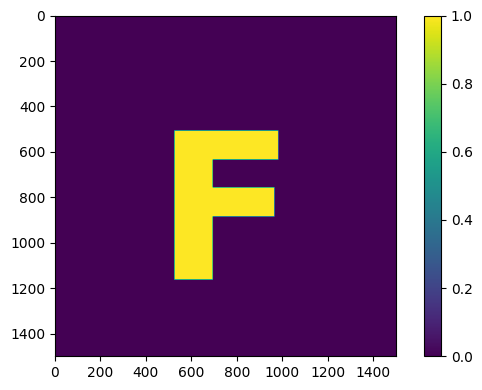

In [5]:
im_real = im_with_text(imsize = (1500,1500), font_size = 900, text = "F", add_offset = (0,-4))
quick_plot(im_real, vmin = 0);

In [6]:
im_real[im_real == 0] = np.nan
#sol_real = solve_Laplace(im_real, n_iters = 25000)
sol_real  = solve_mindist(im_real)
sol_real /= sol_real.max()
sol_real  = 1 - sol_real

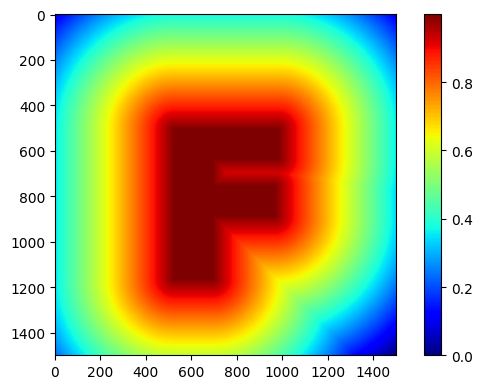

In [7]:
quick_plot(sol_real, cmap = 'jet');

In [8]:
import cv2

class parametrization_getter():
    
    def __init__(self, image, blow_up = 4, show_window = True):
        
        self.image       = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        self.image_big   = cv2.resize(self.image,(int(blow_up*self.image.shape[1]),
                                                  int(blow_up*self.image.shape[0])))
        self.window_name = "Get parametrizations"
        
        self.polygons      = [[]]
        self.polygon_index = 0
        
        
    def update_window(self):
        
        canvas = self.image_big.copy()
        
        for i,polygon in enumerate(self.polygons):
            if len(polygon) > 1:
                
                color  = (200,255,0) if (i == self.polygon_index) else (0,200,0)
                
                points       = np.array(polygon)
                points[:,0] *= self.image_big.shape[1]
                points[:,1] *= self.image_big.shape[0]
                points       = points.astype(int)
                
                canvas = cv2.polylines(canvas, [points],
                                       True, color, 2)
                
                canvas = cv2.circle(canvas, points[0],  3, (0,0,255), -1)
                canvas = cv2.circle(canvas, points[-1], 3, (0,255,0), -1)
                
        cv2.imshow(self.window_name, canvas)
        
        
    def mouse_callback(self, event, x,y, flags, param):
        
        if event == cv2.EVENT_LBUTTONDOWN:
            point = [x/self.image_big.shape[1],y/self.image_big.shape[0]]
            self.polygons[self.polygon_index].append(point)
            self.update_window()
            
        elif event == cv2.EVENT_RBUTTONDOWN:
            polygon = self.polygons[self.polygon_index]
            if len(polygon) > 0:
                self.polygons[self.polygon_index] = polygon[:-1]
                self.update_window()
                
                
    def run(self):
        
        cv2.namedWindow(self.window_name)
        cv2.setMouseCallback(self.window_name,self.mouse_callback)
        
        self.update_window()
        
        while True:
            key = cv2.waitKey(0)
            
            if key == ord('q'):
                cv2.destroyAllWindows()
                break
                
            elif key == ord('n'):
                if self.polygon_index == len(self.polygons)-1:
                    self.polygons.append([])
                    
                self.polygon_index += 1
                self.update_window()
                
            elif key == ord('p'):
                self.polygon_index = max(0, self.polygon_index-1)
                self.update_window()
                
            elif key == ord('d'):
                
                if len(self.polygons) > 1:
                    del self.polygons[self.polygon_index]
                
                self.polygon_index = min(len(self.polygons)-1, self.polygon_index)
                
                
    def get_grid(self, point_density = 2, by_arclength = False, make_continuous = True):
        grid = np.full(self.image.shape[:2], np.nan, dtype = np.float32)
        
        for k,polygon in enumerate(self.polygons):
            
            if len(polygon) == 0:
                continue
            
            points       = np.array(polygon + [polygon[0]], dtype = np.float32)    
            points[:,0] *= self.image.shape[1]-1
            points[:,1] *= self.image.shape[0]-1
            dists        = np.linalg.norm(points[:-1] - points[1:], axis = 1)
            Csum         = dists.cumsum(0)
            n_points     = int(point_density*Csum[-1].item())
            end          = Csum[-1] if by_arclength else 1
            
            u = np.linspace(0,Csum[-1],n_points)
            i = np.searchsorted(Csum, u)
            
            Csum_with_0 = np.concatenate([np.zeros(1),Csum])
            
            t = (u-Csum_with_0[i])/dists[i]
            
            t = t[:,None]
            
            coords = (t*points[i+1]+(1-t)*points[i]).round().astype(int)

            grid[coords[:,1],
                 coords[:,0]] = np.linspace(0,Csum[-1] if by_arclength else 1,
                                            n_points)
            
        if make_continuous:
            where_values = ~np.isnan(grid)
            
            if make_continuous:
                #vals = np.sin(np.pi*grid[where_values])**2
                vals = 1-2*np.abs(grid[where_values]-0.5)
                
            grid[where_values] = vals
            
        return grid
    
    def save_polygons(self,filename):
        
        data_dict = dict()
        
        for i,polygon in enumerate(self.polygons):
            data_dict[str(i)] = np.array(polygon)
            
        with open(filename, 'wb') as f:
            np.savez(f, **data_dict)
            
    def load_polygons(self,filename):      
        with open(filename, 'rb') as f:
            
            for polygon in np.load(f).values():
                self.polygons.append([list(polygon[i]) for i in range(polygon.shape[0])])

In [9]:
PG = parametrization_getter(im_real, blow_up = 0.5)

PG.run()
PG.save_polygons("FRACTAL.npz")

In [22]:
PG.load_polygons("FRACTAL.npz")

In [11]:
im_imag = PG.get_grid()

In [12]:
# sol_imag_1 = solve_Laplace(im_imag, BC_Dirichlet = False, n_iters = 100000, init_value = 0.5)
sol_imag = solve_closest(im_imag)

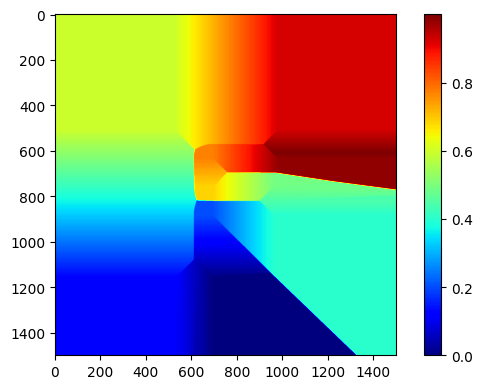

In [13]:
quick_plot(sol_imag, cmap = 'jet');

In [14]:
@cuda.jit
def Mandelbrot_kernel(Z, C, Div, Iters, n_iters_max):
    
    i,j = cuda.grid(2)
    
    if (i >= Z.shape[0]) or (j >= Z.shape[1]) or Div[i,j]:
        return
    
    z   = Z[i,j]
    c   = C[i,j]
    
    for n in range(1,n_iters_max+1):
        z     = z*z + c
        abssq = z.real*z.real + z.imag*z.imag
        
        if abssq > 4:
            Div[i,j] = True
            break
        
    Z[i,j]      = z
    Iters[i,j] += n

In [15]:
import cupy as cp
    
class Mandelbrot_artist():
    
    def __init__(self,
                 colors: list    = [[100,10,10],[255,100,100]]):
        
        self.colours      = colors
        self.shades_per_c = 500
        
        self.get_colormap()
        
    def get_colormap(self):
        
        colours_looped = cp.array(self.colours + [self.colours[0]])
        f              = cp.linspace(0,1,self.shades_per_c)[:-1,None]
        shades_all     = []
        
        for i in range(len(self.colours)):
            
            shades   = ((1-f) *colours_looped[i][None,:] + 
                        (f)   *colours_looped[i+1][None,:]).astype(cp.uint8)
            
            shades_all.append(shades)
            
        self.colormap = cp.concatenate(shades_all)  
        
    def colour(self, Iters, Div, offset = 0):
        self.fractal_im      = cp.zeros((*Iters.shape,3), dtype = cp.uint8)
        self.fractal_im[Div] = self.colormap[(Iters[Div] + offset) % len(self.colormap)]

In [16]:
from math import ceil

class Solutions_to_fractal():
    
    def __init__(self, sol_real, sol_imag,
                 c_inv = -5/4,
                 r_inv =  1/2):
        
        self.sol_real = sol_real
        self.sol_imag = sol_imag
        
        self.c_inv = c_inv
        self.r_inv = r_inv
        
        self.scale_imag     = 2
        self.scale_real     = 0.5
        self.translate_imag = 0
        
        self.MA = Mandelbrot_artist()
        
        
    def invert(self,Z):
        diff = Z - self.c_inv
        return self.c_inv + diff*np.square(self.r_inv/np.abs(diff))
    
    def get_complex_grid(self, grid_real_power = 0.5, sol_real_offset = 1e-3):
        
#         grid_real = self.grid_real
        
#         grid_real_min = grid_real.min()
#         grid_real_max = grid_real.max()
        
#         grid_real_scaled = (grid_real-grid_real_min)/(grid_real_max-grid_real_min)
#         grid_real        = (1-grid_real_scale_factor)*grid_real + grid_real_scale_factor*grid_real_scaled
        
#         grid_real = self.c_inv - self.r_inv + 2*self.r_inv*grid_real**grid_real_power
#         grid_real = self.c_inv - self.r_inv + (1+self.scale_real*(-1+self.grid_real**grid_real_power))*2*self.r_inv
#         grid_imag = self.scale_imag*self.grid_imag + self.translate_imag
#         grid_comp = torch.complex(grid_real,grid_imag)
        
#         self.grid_comp = self.invert(grid_comp)

        grid_real = self.c_inv - self.r_inv + 2*self.r_inv*(self.sol_real + sol_real_offset)**grid_real_power
        grid_imag = self.scale_imag*self.sol_imag + self.translate_imag

        self.grid_comp = self.invert(grid_real + 1j*grid_imag)
        
        
    def save_complex_grid(self, filename = 'complex_grid.npy'):
        with open(filename, 'wb') as f:
            np.save(f,self.grid_comp.detach().cpu().numpy())
        
    @staticmethod
    def Mandelbrot(complex_grid,
                   n_iters = 100,
                   threads_per_block = (16,16)):
    
        C     = cuda.to_device(complex_grid)
        Z     = cuda.device_array_like(C)
        Div   = cuda.device_array(C.shape, dtype = bool)
        Iters = cuda.device_array(C.shape, dtype = np.uint32)
        
        Z[:]     = 0.
        Iters[:] = 0
        Div[:]   = False
        
        S = complex_grid.shape
    
        blocks_per_grid = (ceil(S[0]/threads_per_block[0]),
                           ceil(S[1]/threads_per_block[1]))

        Mandelbrot_kernel[blocks_per_grid,
                          threads_per_block](Z, C, Div, Iters, n_iters)
        
        Iters_host = Iters.copy_to_host()
        Div_host   = Div.copy_to_host()
        
        return Iters_host, Div_host
    
    
    def show_wrapper(self, n_pixels_real = 100, n_iters = 100, **kwargs):
        
        real_max = self.c_inv + self.r_inv
        real_min = real_max - self.scale_real*2*self.r_inv
        imag_min = self.translate_imag
        imag_max = imag_min + self.scale_imag
        
        n_pixels_imag = int(n_pixels_real*(imag_max-imag_min)/(real_max-real_min))
        real          = np.linspace(real_min,real_max,n_pixels_real)
        imag          = np.linspace(imag_min,imag_max,n_pixels_imag)
        real,imag     = np.meshgrid(real,imag, indexing = 'ij')
        comp          = self.invert(real + 1j*imag)
        raw, div      = Solutions_to_fractal.Mandelbrot(comp, n_iters = n_iters)
        
        self.MA.colour(raw,div)
        im = cp.asnumpy(self.MA.fractal_im)
        
        
        
        fig, ax = quick_plot(im, colorbar = False, extent = [imag_min,imag_max,real_min,real_max], **kwargs)
        
        ax.set_ylabel("real")
        ax.set_xlabel("Imaginary")
        ax.set_title("Wrapper")
        fig.tight_layout()
        
        return fig,ax
        

In [17]:
points = [-0.75,
-1.25,
-1.3680989,
-1.3940462,
-1.3996312,
-1.4008287,
-1.4010853,
-1.4011402,
-1.401151982029,
-1.401154502237]

def get_inv_param(i):

    c_bulb =  (points[i+1]+points[i])/2
    r_bulb = -(points[i+1]-points[i])/2

    c_inv = c_bulb-r_bulb
    r_inv = 2*r_bulb
    
    return c_inv, r_inv

In [18]:
c_inv, r_inv = get_inv_param(0)

STF = Solutions_to_fractal(sol_real,sol_imag, c_inv = c_inv, r_inv = r_inv)

C:\Users\bart1\miniconda3\envs\MEP\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 40 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
C:\Users\bart1\miniconda3\envs\MEP\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 40 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
C:\Users\bart1\miniconda3\envs\MEP\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 40 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


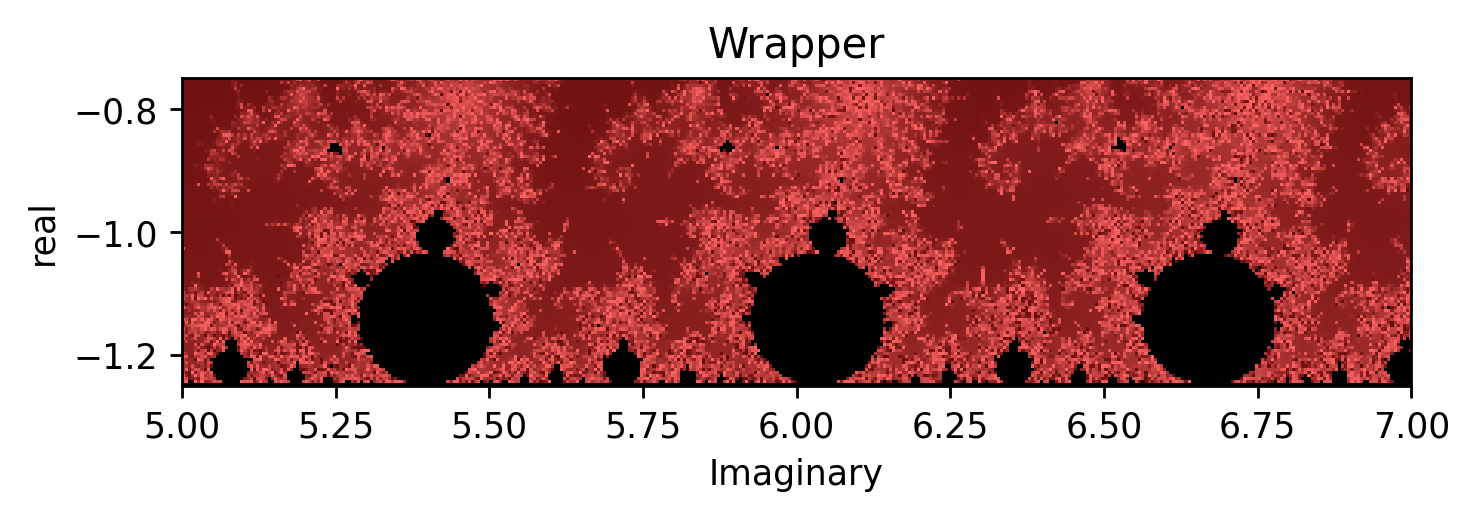

In [19]:
STF.scale_imag     = 2
STF.translate_imag = 5
STF.show_wrapper(n_iters = 100000, dpi = 250);

In [20]:
STF.get_complex_grid(grid_real_power = 1, sol_real_offset = 1e-2)
raw, div = Solutions_to_fractal.Mandelbrot(STF.grid_comp, n_iters = 100000)

(<Figure size 1500x1000 with 1 Axes>, <AxesSubplot:>)

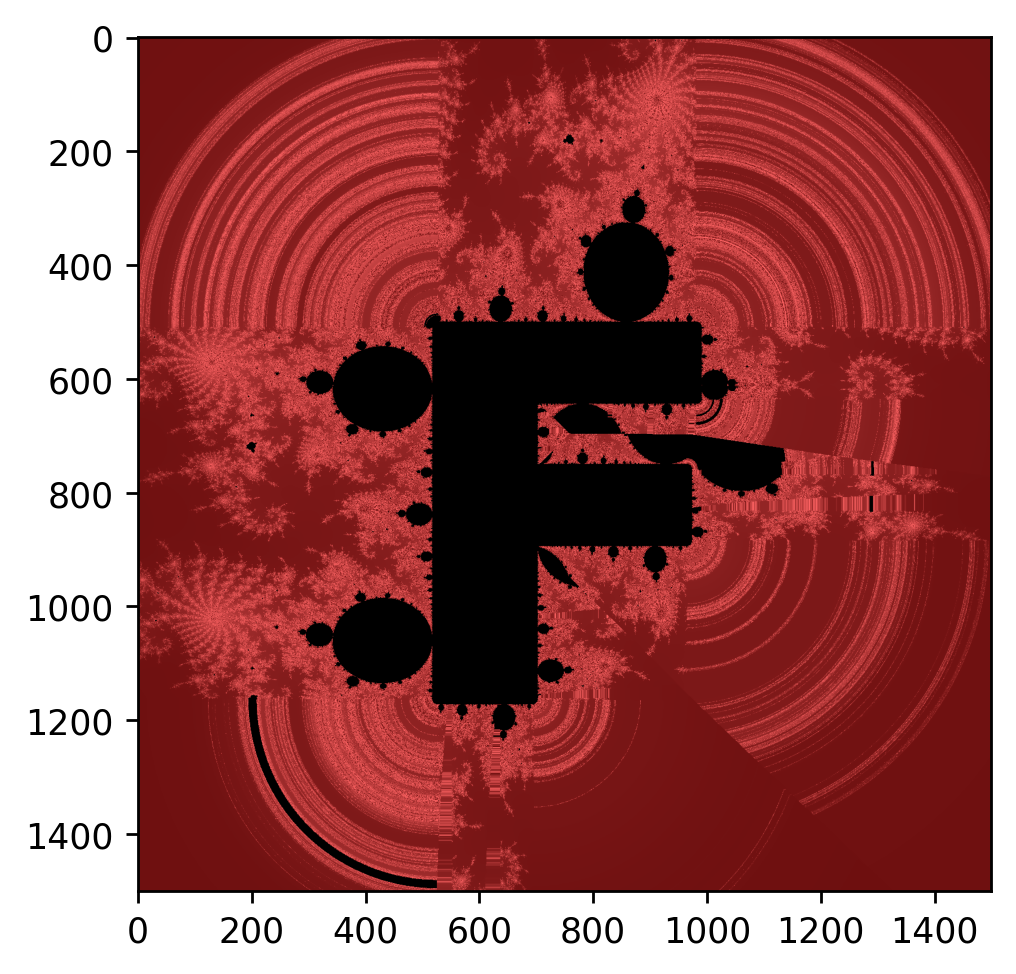

In [21]:
STF.MA.colour(raw,div)
quick_plot(cp.asnumpy(STF.MA.fractal_im), colorbar = False, dpi = 250)